<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [ ]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [ ]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[2] #Normal with RE
test_file = file_path+file[3]
dataset= "Normal with Response Encoding"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 373), (11403, 373), (75818, 373))

In [ ]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [ ]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [ ]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [ ]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   58.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.6min finished


The best auc score was 0.811
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.97 s, sys: 1.3 s, total: 10.3 s
Wall time: 3min 37s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal with Response Encoding dataset 		 



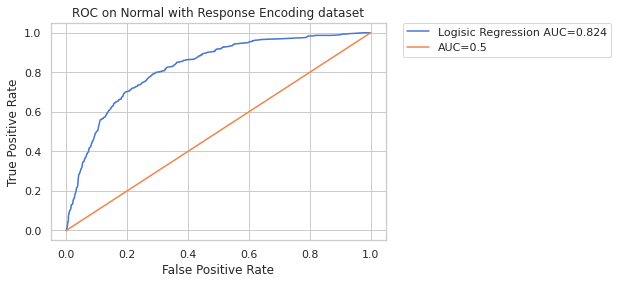

The log loss and auc was found to be 0.524 and 0.824 for Logisic Regression on Normal with Response Encoding dataset.


In [ ]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


The best auc score was 0.758
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.36 s, sys: 247 ms, total: 5.6 s
Wall time: 5min 21s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal with Response Encoding dataset 		 



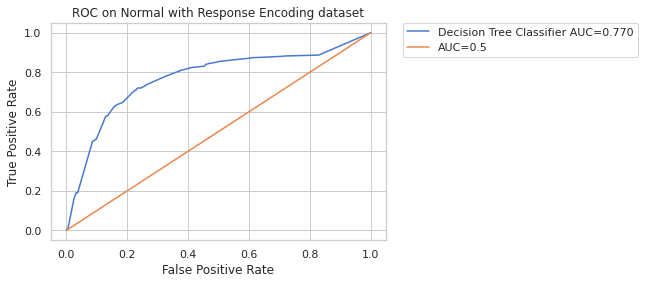

The log loss and auc was found to be 0.149 and 0.770 for Decision Tree Classifier on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 41.1min finished


The best auc score was 0.823
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 500, 'max_depth': 1000}
CPU times: user 6min 33s, sys: 1.06 s, total: 6min 34s
Wall time: 47min 42s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 10min 23s, sys: 1.22 s, total: 10min 25s
Wall time: 5min 17s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=500,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal with Response Encoding dataset 		 



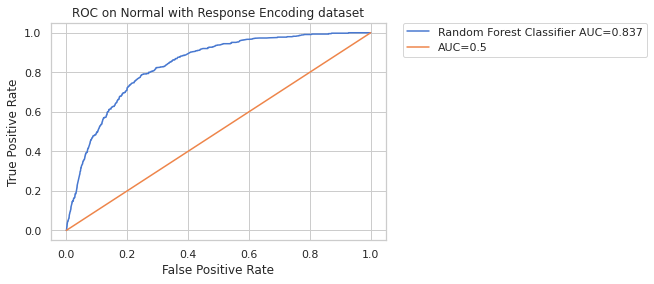

The log loss and auc was found to be 0.137 and 0.837 for Random Forest Classifier on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804


# Selecting top features

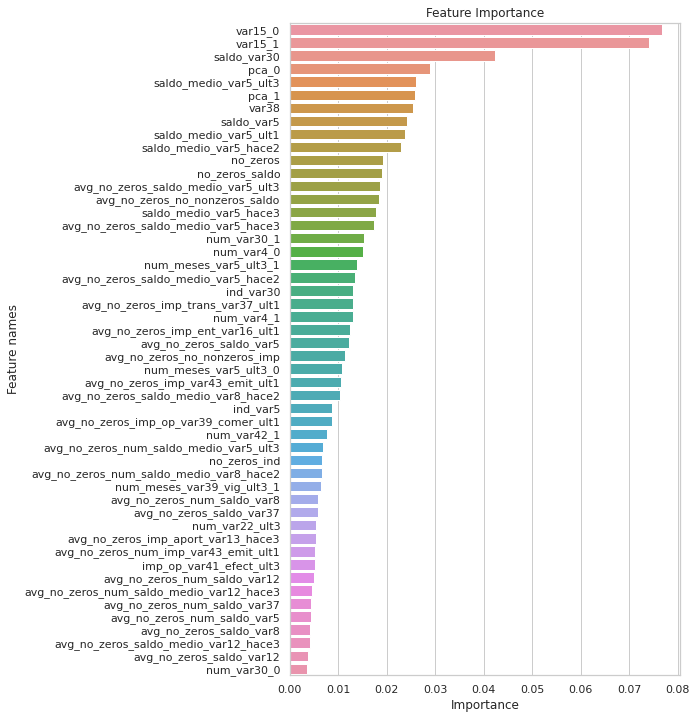

In [ ]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [ ]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_val[features].copy()

There are 29 features that have feature importance value above 0.01000


In [ ]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_val[features].copy()

Taking top 100 features


In [ ]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_val[features].copy()

Taking top 250 features


# XGB Classifier

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=100,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5,
                     )
#validation_0-auc:0.84556

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.783915	validation_0-error:0.040077
[1]	validation_0-auc:0.798391	validation_0-error:0.039639
[2]	validation_0-auc:0.815051	validation_0-error:0.039551
[3]	validation_0-auc:0.816881	validation_0-error:0.039551
[4]	validation_0-auc:0.815393	validation_0-error:0.039551
[5]	validation_0-auc:0.819131	validation_0-error:0.039551
[6]	validation_0-auc:0.819046	validation_0-error:0.039551
[7]	validation_0-auc:0.818916	validation_0-error:0.039551
[8]	validation_0-auc:0.82209	validation_0-error:0.039551
[9]	validation_0-auc:0.824916	validation_0-error:0.039551
[10]	validation_0-auc:0.824179	validation_0-error:0.039551
[11]	validation_0-auc:0.825422	validation_0-error:0.039551
[12]	validation_0-auc:0.823926	validation_0-error:0.039551
[13]	validation_0-auc:0.822727	validation_0-error:0.039551
[14]	validation_0-auc:0.821906	validation_0-error:0.039551
[15]	validation_0-auc:0.826936	validation_0-error:0.039551
[16]	validation_0-auc:0.827526	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Normal with Response Encoding dataset 		 



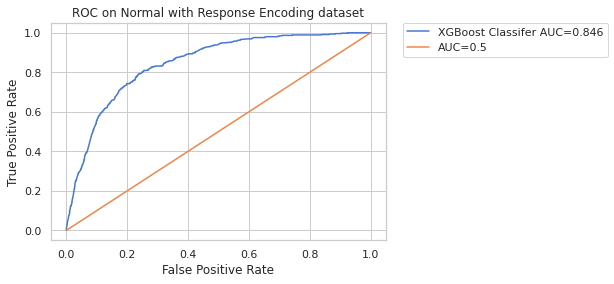

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604


# LightGBM Classifier

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,
                     )
#valid_0's auc: 0.845998

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165833	valid_0's auc: 0.795107
[2]	valid_0's binary_logloss: 0.165152	valid_0's auc: 0.816533
[3]	valid_0's binary_logloss: 0.16449	valid_0's auc: 0.820887
[4]	valid_0's binary_logloss: 0.163816	valid_0's auc: 0.829326
[5]	valid_0's binary_logloss: 0.163277	valid_0's auc: 0.828935
[6]	valid_0's binary_logloss: 0.162734	valid_0's auc: 0.829175
[7]	valid_0's binary_logloss: 0.162099	valid_0's auc: 0.830957
[8]	valid_0's binary_logloss: 0.161592	valid_0's auc: 0.830361
[9]	valid_0's binary_logloss: 0.161045	valid_0's auc: 0.831672
[10]	valid_0's binary_logloss: 0.160486	valid_0's auc: 0.833393
[11]	valid_0's binary_logloss: 0.159983	valid_0's auc: 0.833841
[12]	valid_0's binary_logloss: 0.159516	valid_0's auc: 0.833707
[13]	valid_0's binary_logloss: 0.1591	valid_0's auc: 0.832951
[14]	valid_0's binary_logloss: 0.158612	valid_0's auc: 0.834117
[15]	valid_0's binary_logloss: 0.158114	valid_0's auc: 0.83524
[16]	valid_0's binary_logloss: 0.157723	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal with Response Encoding dataset 		 



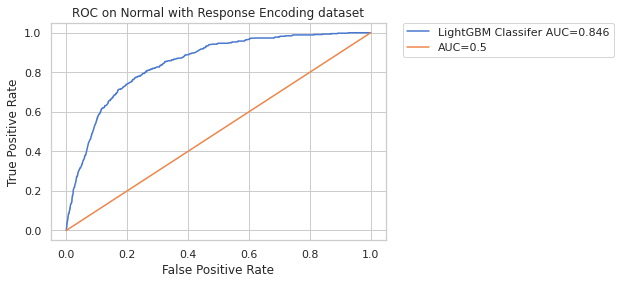

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.2min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 100, 'max_depth': 2000}
CPU times: user 1min 28s, sys: 271 ms, total: 1min 28s
Wall time: 42min 38s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=100,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Normal with Response Encoding dataset 		 



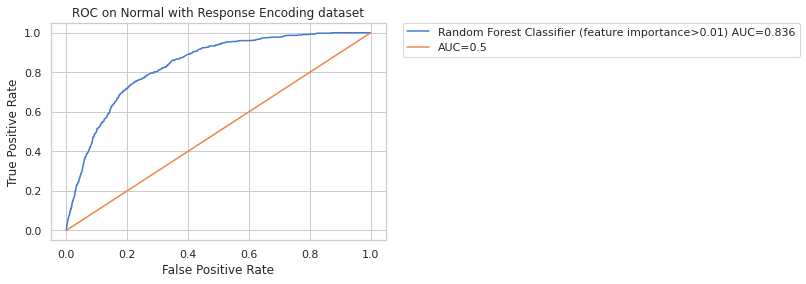

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956


# XGB Classifier (feature importance>0.01)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.0
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.808314	validation_0-error:0.039639
[1]	validation_0-auc:0.811076	validation_0-error:0.039551
[2]	validation_0-auc:0.817751	validation_0-error:0.039551
[3]	validation_0-auc:0.820725	validation_0-error:0.039551
[4]	validation_0-auc:0.819243	validation_0-error:0.039551
[5]	validation_0-auc:0.819492	validation_0-error:0.039551
[6]	validation_0-auc:0.819577	validation_0-error:0.039551
[7]	validation_0-auc:0.819505	validation_0-error:0.039551
[8]	validation_0-auc:0.819674	validation_0-error:0.039551
[9]	validation_0-auc:0.819538	validation_0-error:0.039551
[10]	validation_0-auc:0.82057	validation_0-error:0.039551
[11]	validation_0-auc:0.820534	validation_0-error:0.039551
[12]	validation_0-auc:0.820343	validation_0-error:0.039551
[13]	validation_0-auc:0.821316	validation_0-error:0.039551
[14]	validation_0-auc:0.821234	validation_0-error:0.039551
[15]	validation_0-auc:0.821731	validation_0-error:0.039551
[16]	validation_0-auc:0.821432	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Normal with Response Encoding dataset 		 



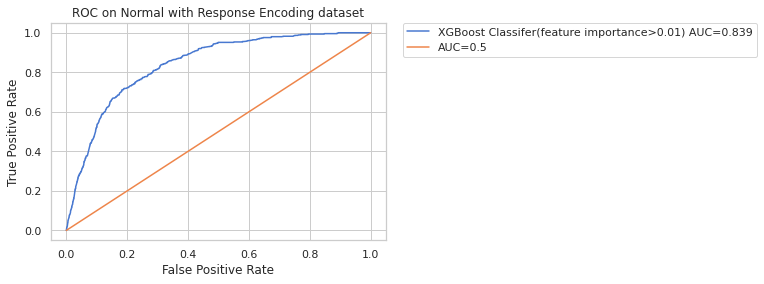

The log loss and auc was found to be 0.135 and 0.839 for XGBoost Classifer(feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435


# LightGBM Classifier (feature importance>0.01)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=740,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165764	valid_0's auc: 0.814947
[2]	valid_0's binary_logloss: 0.165085	valid_0's auc: 0.823823
[3]	valid_0's binary_logloss: 0.164375	valid_0's auc: 0.826119
[4]	valid_0's binary_logloss: 0.163702	valid_0's auc: 0.826252
[5]	valid_0's binary_logloss: 0.163064	valid_0's auc: 0.826624
[6]	valid_0's binary_logloss: 0.162433	valid_0's auc: 0.827457
[7]	valid_0's binary_logloss: 0.161869	valid_0's auc: 0.828618
[8]	valid_0's binary_logloss: 0.161293	valid_0's auc: 0.82936
[9]	valid_0's binary_logloss: 0.160744	valid_0's auc: 0.828899
[10]	valid_0's binary_logloss: 0.1602	valid_0's auc: 0.829453
[11]	valid_0's binary_logloss: 0.159687	valid_0's auc: 0.82918
[12]	valid_0's binary_logloss: 0.159202	valid_0's auc: 0.828877
[13]	valid_0's binary_logloss: 0.158771	valid_0's auc: 0.829944
[14]	valid_0's binary_logloss: 0.158332	valid_0's auc: 0.83102
[15]	valid_0's binary_logloss: 0.157881	valid_0's auc: 0.831903
[16]	valid_0's binary_logloss: 0.157457	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=740, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Normal with Response Encoding dataset 		 



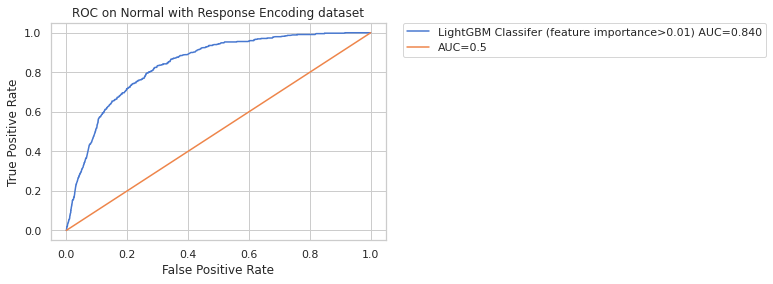

The log loss and auc was found to be 0.135 and 0.840 for LightGBM Classifer (feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.4min finished


The best auc score was 0.824
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 4min 4s, sys: 534 ms, total: 4min 4s
Wall time: 44min 31s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Normal with Response Encoding dataset 		 



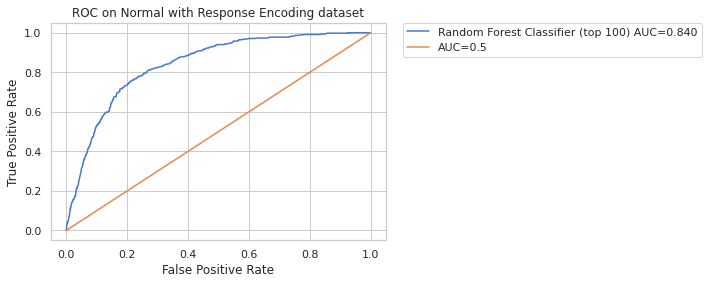

The log loss and auc was found to be 0.136 and 0.840 for Random Forest Classifier (top 100) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121


# XGB Classifier (top 100)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 1,
                      max_depth=7, 
                      gamma=0,
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.808234	validation_0-error:0.039639
[1]	validation_0-auc:0.823689	validation_0-error:0.039551
[2]	validation_0-auc:0.824319	validation_0-error:0.039551
[3]	validation_0-auc:0.822518	validation_0-error:0.039551
[4]	validation_0-auc:0.823054	validation_0-error:0.039639
[5]	validation_0-auc:0.822488	validation_0-error:0.039551
[6]	validation_0-auc:0.82418	validation_0-error:0.039551
[7]	validation_0-auc:0.824776	validation_0-error:0.039551
[8]	validation_0-auc:0.827309	validation_0-error:0.039551
[9]	validation_0-auc:0.826041	validation_0-error:0.039551
[10]	validation_0-auc:0.8241	validation_0-error:0.039551
[11]	validation_0-auc:0.82371	validation_0-error:0.039551
[12]	validation_0-auc:0.824632	validation_0-error:0.039551
[13]	validation_0-auc:0.824707	validation_0-error:0.039551
[14]	validation_0-auc:0.82728	validation_0-error:0.039551
[15]	validation_0-auc:0.827637	validation_0-error:0.039551
[16]	validation_0-auc:0.827838	validation_0-error:0.039551
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Normal with Response Encoding dataset 		 



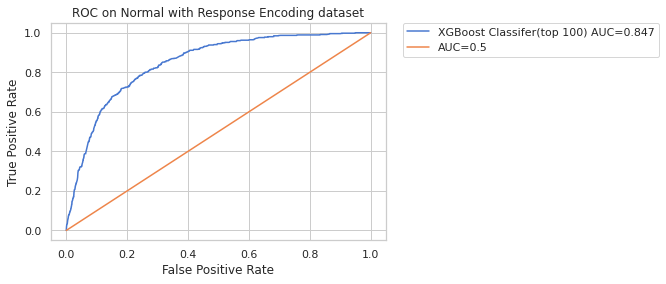

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121
11,XGBoost Classifer(top 100),Normal with Response Encoding,0.132838,0.846913


# LightGBM Classifier (top 100)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=6, 
                      gamma=0,
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165793	valid_0's auc: 0.802858
[2]	valid_0's binary_logloss: 0.165149	valid_0's auc: 0.80914
[3]	valid_0's binary_logloss: 0.164527	valid_0's auc: 0.809135
[4]	valid_0's binary_logloss: 0.163912	valid_0's auc: 0.813998
[5]	valid_0's binary_logloss: 0.16328	valid_0's auc: 0.824364
[6]	valid_0's binary_logloss: 0.162684	valid_0's auc: 0.828158
[7]	valid_0's binary_logloss: 0.162066	valid_0's auc: 0.829955
[8]	valid_0's binary_logloss: 0.161562	valid_0's auc: 0.830823
[9]	valid_0's binary_logloss: 0.160999	valid_0's auc: 0.832722
[10]	valid_0's binary_logloss: 0.160458	valid_0's auc: 0.833042
[11]	valid_0's binary_logloss: 0.159975	valid_0's auc: 0.832575
[12]	valid_0's binary_logloss: 0.159441	valid_0's auc: 0.834091
[13]	valid_0's binary_logloss: 0.158952	valid_0's auc: 0.834725
[14]	valid_0's binary_logloss: 0.158524	valid_0's auc: 0.834513
[15]	valid_0's binary_logloss: 0.158078	valid_0's auc: 0.834804
[16]	valid_0's binary_logloss: 0.157675	valid_0's a

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=947, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.4, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Normal with Response Encoding dataset 		 



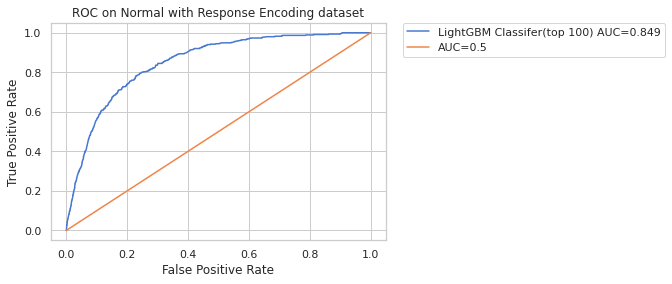

The log loss and auc was found to be 0.132 and 0.849 for LightGBM Classifer(top 100) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121
11,XGBoost Classifer(top 100),Normal with Response Encoding,0.132838,0.846913


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 58.7min finished


The best auc score was 0.822
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 4min 58s, sys: 640 ms, total: 4min 59s
Wall time: 1h 3min 42s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 200) on Normal with Response Encoding dataset 		 



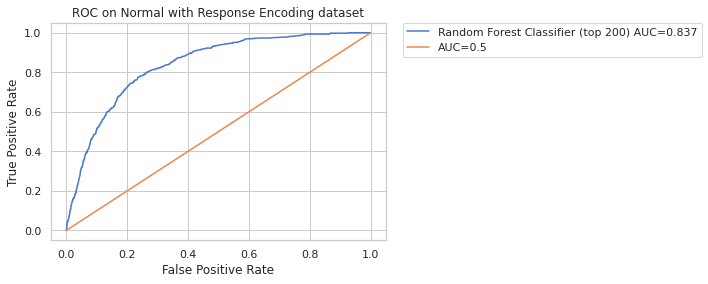

The log loss and auc was found to be 0.136 and 0.837 for Random Forest Classifier (top 200) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121
11,XGBoost Classifer(top 100),Normal with Response Encoding,0.132838,0.846913


# XGB Classifier (top 250)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0,
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.786612	validation_0-error:0.040077
[1]	validation_0-auc:0.803429	validation_0-error:0.039639
[2]	validation_0-auc:0.818305	validation_0-error:0.039551
[3]	validation_0-auc:0.819096	validation_0-error:0.039551
[4]	validation_0-auc:0.819341	validation_0-error:0.039551
[5]	validation_0-auc:0.820067	validation_0-error:0.039551
[6]	validation_0-auc:0.820665	validation_0-error:0.039551
[7]	validation_0-auc:0.820419	validation_0-error:0.039551
[8]	validation_0-auc:0.821875	validation_0-error:0.039551
[9]	validation_0-auc:0.823909	validation_0-error:0.039551
[10]	validation_0-auc:0.823848	validation_0-error:0.039551
[11]	validation_0-auc:0.822905	validation_0-error:0.039551
[12]	validation_0-auc:0.823765	validation_0-error:0.039551
[13]	validation_0-auc:0.824183	validation_0-error:0.039551
[14]	validation_0-auc:0.824386	validation_0-error:0.039551
[15]	validation_0-auc:0.825504	validation_0-error:0.039551
[16]	validation_0-auc:0.82531	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 200) on Normal with Response Encoding dataset 		 



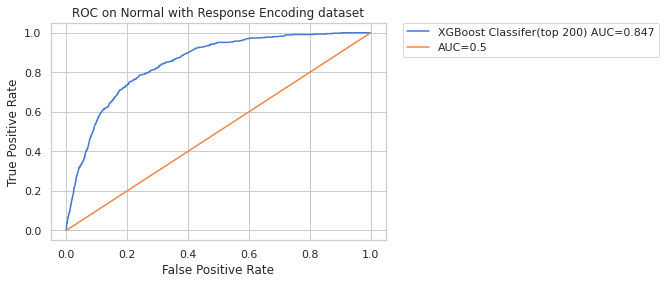

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 200) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
2,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
3,Decision Tree Classifier,Normal with Response Encoding,0.148920,0.770003
4,Random Forest Classifier,Normal with Response Encoding,0.136697,0.836804
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
7,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136650,0.835956
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121
11,XGBoost Classifer(top 100),Normal with Response Encoding,0.132838,0.846913


# LightGBM Classifier (top 250)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=7,
                      gamma=5,
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165792	valid_0's auc: 0.806093
[2]	valid_0's binary_logloss: 0.1651	valid_0's auc: 0.814896
[3]	valid_0's binary_logloss: 0.164439	valid_0's auc: 0.822009
[4]	valid_0's binary_logloss: 0.163767	valid_0's auc: 0.822632
[5]	valid_0's binary_logloss: 0.163169	valid_0's auc: 0.827179
[6]	valid_0's binary_logloss: 0.162624	valid_0's auc: 0.827009
[7]	valid_0's binary_logloss: 0.162074	valid_0's auc: 0.827946
[8]	valid_0's binary_logloss: 0.161509	valid_0's auc: 0.829707
[9]	valid_0's binary_logloss: 0.16093	valid_0's auc: 0.831127
[10]	valid_0's binary_logloss: 0.160405	valid_0's auc: 0.831001
[11]	valid_0's binary_logloss: 0.159906	valid_0's auc: 0.832422
[12]	valid_0's binary_logloss: 0.159366	valid_0's auc: 0.834265
[13]	valid_0's binary_logloss: 0.158867	valid_0's auc: 0.835732
[14]	valid_0's binary_logloss: 0.158424	valid_0's auc: 0.835833
[15]	valid_0's binary_logloss: 0.157966	valid_0's auc: 0.83632
[16]	valid_0's binary_logloss: 0.157469	valid_0's auc

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=447, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 200) on Normal with Response Encoding dataset 		 



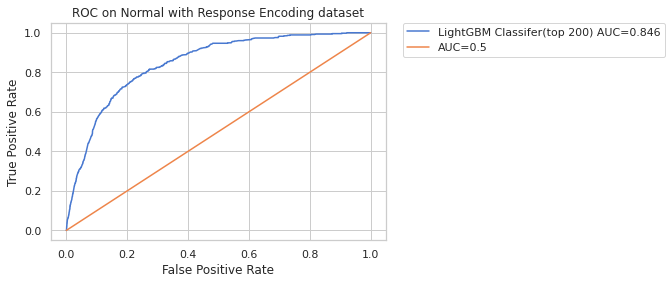

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer(top 200) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

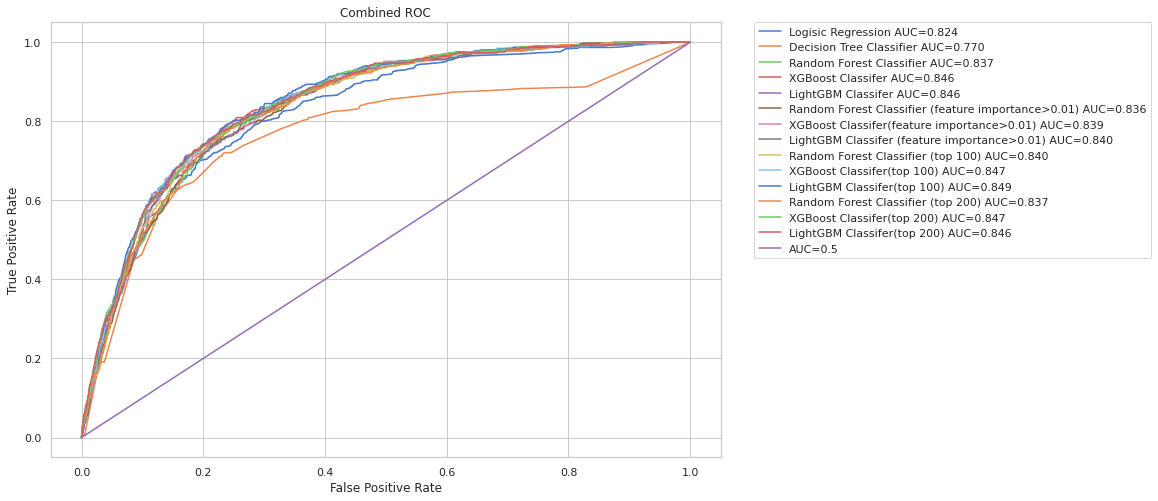

In [ ]:
plot_auc(y_val,y_preds,labels)

In [ ]:
result_df.sort_values(by='log_loss')

,Model,Dataset,log_loss,auc
12,LightGBM Classifer(top 100),Normal with Response Encoding,0.132227,0.849490
11,XGBoost Classifer(top 100),Normal with Response Encoding,0.132838,0.846913
15,XGBoost Classifer(top 200),Normal with Response Encoding,0.132911,0.847031
6,LightGBM Classifer,Normal with Response Encoding,0.132985,0.846373
16,LightGBM Classifer(top 200),Normal with Response Encoding,0.133062,0.846400
5,XGBoost Classifer,Normal with Response Encoding,0.133297,0.845604
9,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134933,0.839705
8,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.135017,0.839435
10,Random Forest Classifier (top 100),Normal with Response Encoding,0.135573,0.840121
14,Random Forest Classifier (top 200),Normal with Response Encoding,0.136419,0.837393
